In [108]:
import cv2
import heapq
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from scipy.spatial import ConvexHull, convex_hull_plot_2d

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [109]:
from src import create_map
from src.create_map import load_obstacles
from src.create_map import load_goal
from src.create_map import map2img

In [110]:
class Edge(object):
    def __init__(self, point, weight):
        self.point = point
        self.weight = weight
    
    def __repr__(self):
        return "Edge({}, {})".format(self.point, self.weight)

In [111]:
class Point(object):
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y
        self.id = '{},{}'.format(self.x, self.y)
        self.edges = {}
        self.cost = float("inf")
        self.parent = None
        self.visited = False
    
    def add_edge(self, point):
        if point.id not in self.edges:
            weight = np.sqrt((point.x - self.x)**2 + (point.y - self.y)**2)
            self.edges[point.id] = Edge(point, weight)

    def __repr__(self):
        return "Point(x={}, y={})".format(self.x, self.y)

    def __lt__(self, point):
        return (self.cost < point.cost)
    
    def __le__(self, point):
        return self.cost <= point.cost
    
    def __gt__(self, point):
        return self.cost > point.cost
    
    def __ge__(self, point):
        return self.cost >= point.cost
    
    def __eq__(self, point):
        return self.cost == point.cost
    
    def __neq__(self, point):
        return self.cost != point.cost

In [112]:
point1 = Point(0, 0)
point1.add_edge(Point(1, 1))
point1

Point(x=0, y=0)

In [113]:
point2 = Point(1, 1)

In [114]:
obstacles = load_obstacles("../data/world_obstacles.txt")

In [115]:
# The map we use in RViz is 1200cm by 600cm, 
# top left and bottom right are (-300, 300) and (900, -300) respectively. 

# Also note that cells in the RViz grid are 50cm by 50cm, 
# The start position of the robot is always at (0, 0), 
# facing x-positive and the goal is defined in data/goal.txt. 
# assume the robot to be a 36cm-by-36cm square

# The obstacles are orange polygons and the goal is a purple dot. 

# More about using the map_server package here.

# robot to be a 36cm-by-36cm square.

In [116]:
# for each obstacle, generate four squares which adds the padding of 18 - 18 to each point of the obstacle

In [117]:
obstacles

[[[100, 0], [100, 50], [150, 0]],
 [[225, 25], [275, 25], [325, -25], [275, -75]],
 [[450, 30], [450, 130], [525, 130], [525, 30]],
 [[400, -50], [400, -100], [425, -50]],
 [[300, 100], [300, 150], [350, 150], [350, 100]]]

In [118]:
goal = load_goal("../data/goal.txt")

In [119]:
start = [0, 0]

## expand obstacles and convex hull

In [120]:
# get expanded obstacles
hulls = []
temp_obstacles = []
grown_obstacles = []
padded_simplices = []
for obstacle in obstacles:
    expanded_obstacles = []
    for point in obstacle:
        expanded_obstacles.append(point)
        expanded_obstacles.append([point[0] - 18, point[1] - 18])
        expanded_obstacles.append([point[0] + 18, point[1] + 18])
        expanded_obstacles.append([point[0] + 18, point[1] - 18])
        expanded_obstacles.append([point[0] - 18, point[1] + 18])
    expanded_obstacles = np.array(expanded_obstacles)
    temp_obstacles.append(expanded_obstacles)
    hull = ConvexHull(expanded_obstacles)
    
    x = expanded_obstacles[hull.vertices, 0]
    y = expanded_obstacles[hull.vertices, 1]
    points = np.stack((x, y), axis=-1)
    grown_obstacles.append(points)
    
    simplices = np.stack((expanded_obstacles[hull.simplices, 0], 
                          expanded_obstacles[hull.simplices, 1]), 
                         axis=1)
    padded_simplices.append(simplices)
    
    hulls.append(hull)

### draw the convex hull of the grown obstacles

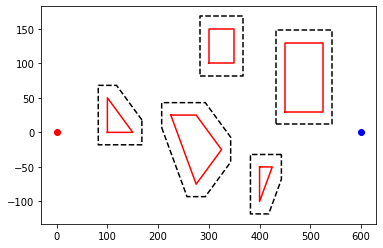

In [121]:
plt.plot(start[0], start[1], 'or')

for idx, obstacle in enumerate(obstacles):
    x = [point[0] for point in obstacle]
    y = [point[1] for point in obstacle]
    x.append(obstacle[0][0])
    y.append(obstacle[0][1])
    
    plt.plot(x, y, 'r-')

for obstacle in grown_obstacles:
    x = obstacle[:,0]
    y = obstacle[:,1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    plt.plot(x, y, '--k')

plt.plot(goal[0], goal[1], 'ob')

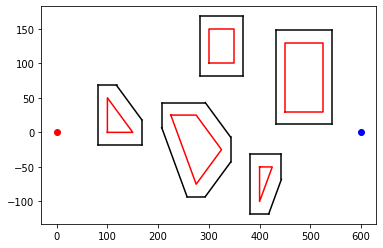

In [122]:
plt.plot(start[0], start[1], 'or')

for idx, obstacle in enumerate(obstacles):
    x = [point[0] for point in obstacle]
    y = [point[1] for point in obstacle]
    x.append(obstacle[0][0])
    y.append(obstacle[0][1])
    
    plt.plot(x, y, 'r-')

for idx, simplices in enumerate(padded_simplices):
    for simplex in simplices:
        plt.plot(simplex[0], simplex[1], 'k-')
plt.plot(goal[0], goal[1], 'ob')

In [123]:
# for collision detection: checking if line segments intersect

class Direction:
    CLOCKWISE = 0
    ANTI_CLOCKWISE = 1
    COLINEAR = 2
    
EPSILON = 0

def point_lie_on_segment(point1, point2, point3, epsilon=EPSILON):
    if min(point1.x, point2.x) - epsilon <= point3.x <= max(point1.x, point2.x) + epsilon and \
        min(point1.y, point2.y) - epsilon <= point3.y <= max(point1.y, point2.y) + epsilon :
        return True
    return False

def compute_orientation(point1, point2, point3, epsilon=EPSILON):
    cross_product = (point2.y - point1.y) * (point3.x - point2.x) -  (point2.x - point1.x) * (point3.y - point2.y)
    
    if abs(cross_product) <= epsilon:
        return Direction.COLINEAR
    elif cross_product > 0:
        return Direction.CLOCKWISE
    elif cross_product < 0:
        return Direction.ANTI_CLOCKWISE

def segment_intersect(point1, point2, point3, point4, epsilon = EPSILON):
    orientation1 = compute_orientation(point1, point2, point3)
    orientation2 = compute_orientation(point1, point2, point4)
    orientation3 = compute_orientation(point3, point4, point1)
    orientation4 = compute_orientation(point3, point4, point2)
    
    if orientation1 != orientation2 and orientation3 != orientation4:
        return True
    
    if orientation1 == Direction.COLINEAR and  point_lie_on_segment(point1, point2, point3, epsilon):
        return True
    
    if orientation2 == Direction.COLINEAR and point_lie_on_segment(point1, point2, point4, epsilon):
        return True

    if orientation3 == Direction.COLINEAR and point_lie_on_segment(point3, point4, point1, epsilon):
        return True
    
    if orientation4 == Direction.COLINEAR and point_lie_on_segment(point3, point4, point2, epsilon):
        return True
    
    return False

In [124]:
start

[0, 0]

In [125]:
goal

[600, 0]

## vgraph

### Algo:
0. Data preprocessing: convert points into a better data structure, define a line segment (point1, point2)
1. compute line segment that are the boundary edge of each obstacle
2. connect the points, from start point to every point in convex hull and goal and from every point of convex hull to other points in other convex hulls and goal
3. remove unseen lines, by removing the edges that intersect with a convex hull edge

In [126]:
# convert all the start and goal into Point(x, y)
start_point = Point(*start)
goal_point = Point(*goal)

In [127]:
# convert all the obstacles into Point(x, y)
obstacle_points = []
for obs in grown_obstacles:
    obs_points = []
    for point in obs:
        obs_points.append(Point(*point))
    obstacle_points.append(obs_points)
obstacle_points

[[Point(x=168, y=18),
  Point(x=118, y=68),
  Point(x=82, y=68),
  Point(x=82, y=-18),
  Point(x=168, y=-18)],
 [Point(x=207, y=7),
  Point(x=257, y=-93),
  Point(x=293, y=-93),
  Point(x=343, y=-43),
  Point(x=343, y=-7),
  Point(x=293, y=43),
  Point(x=207, y=43)],
 [Point(x=432, y=12),
  Point(x=543, y=12),
  Point(x=543, y=148),
  Point(x=432, y=148)],
 [Point(x=443, y=-32),
  Point(x=382, y=-32),
  Point(x=382, y=-118),
  Point(x=418, y=-118),
  Point(x=443, y=-68)],
 [Point(x=282, y=82),
  Point(x=368, y=82),
  Point(x=368, y=168),
  Point(x=282, y=168)]]

In [128]:
# computing line segments for each padded obstacle edges
obstacle_edges = []

# iterate for every obstacle point collections
for obs in obstacle_points:
    obs_point_segments = [(obs[i], obs[i+1]) for i in range(len(obs) - 1) ]
    if len(obs) > 2:
        obs_point_segments.append((obs[-1], obs[0]))
    obstacle_edges.append(obs_point_segments)
obstacle_edges

[[(Point(x=168, y=18), Point(x=118, y=68)),
  (Point(x=118, y=68), Point(x=82, y=68)),
  (Point(x=82, y=68), Point(x=82, y=-18)),
  (Point(x=82, y=-18), Point(x=168, y=-18)),
  (Point(x=168, y=-18), Point(x=168, y=18))],
 [(Point(x=207, y=7), Point(x=257, y=-93)),
  (Point(x=257, y=-93), Point(x=293, y=-93)),
  (Point(x=293, y=-93), Point(x=343, y=-43)),
  (Point(x=343, y=-43), Point(x=343, y=-7)),
  (Point(x=343, y=-7), Point(x=293, y=43)),
  (Point(x=293, y=43), Point(x=207, y=43)),
  (Point(x=207, y=43), Point(x=207, y=7))],
 [(Point(x=432, y=12), Point(x=543, y=12)),
  (Point(x=543, y=12), Point(x=543, y=148)),
  (Point(x=543, y=148), Point(x=432, y=148)),
  (Point(x=432, y=148), Point(x=432, y=12))],
 [(Point(x=443, y=-32), Point(x=382, y=-32)),
  (Point(x=382, y=-32), Point(x=382, y=-118)),
  (Point(x=382, y=-118), Point(x=418, y=-118)),
  (Point(x=418, y=-118), Point(x=443, y=-68)),
  (Point(x=443, y=-68), Point(x=443, y=-32))],
 [(Point(x=282, y=82), Point(x=368, y=82)),
  (Poi

### Removing unseen lines

To remove a non-visible line, we compare two line segments and check if they intersect with an edge that lie on a obstacle boundary.

In [129]:
def extract_non_intersecting_lines(candidate_segments, obstacle_segments):
    lines_not_intersect = []
    for idx1, can_segment in enumerate(candidate_segments):
        intersect = False

        for obs_segment in obstacle_segments:
            # skip checks if the start/end point of a candiate point is the same as the start/end of an obstacle segment
            if point_lie_on_segment(obs_segment[0], obs_segment[1], can_segment[0]):
                continue
            
            if point_lie_on_segment(obs_segment[0], obs_segment[1], can_segment[1]):
                continue

            intersect = segment_intersect(*can_segment, *obs_segment)
            if intersect:
                break

        if not intersect:
            lines_not_intersect.append(can_segment)

    return lines_not_intersect

In [130]:
# combine all the segments of the obstacles
obstacle_segments = list(itertools.chain.from_iterable(obstacle_edges))

In [131]:
# combine all the possible points to create a total graph
all_points = [[start_point]] + obstacle_points + [[goal_point]]
all_points

[[Point(x=0, y=0)],
 [Point(x=168, y=18),
  Point(x=118, y=68),
  Point(x=82, y=68),
  Point(x=82, y=-18),
  Point(x=168, y=-18)],
 [Point(x=207, y=7),
  Point(x=257, y=-93),
  Point(x=293, y=-93),
  Point(x=343, y=-43),
  Point(x=343, y=-7),
  Point(x=293, y=43),
  Point(x=207, y=43)],
 [Point(x=432, y=12),
  Point(x=543, y=12),
  Point(x=543, y=148),
  Point(x=432, y=148)],
 [Point(x=443, y=-32),
  Point(x=382, y=-32),
  Point(x=382, y=-118),
  Point(x=418, y=-118),
  Point(x=443, y=-68)],
 [Point(x=282, y=82),
  Point(x=368, y=82),
  Point(x=368, y=168),
  Point(x=282, y=168)],
 [Point(x=600, y=0)]]

In [132]:
# get all the non-collision segments
all_free_segments = []

for i, points in enumerate(all_points):
    for point in points:
        other_points = [all_points[j] for j in range(i+1, len(all_points))]
        other_points = list(itertools.chain.from_iterable(other_points))
        candidate_segments = [(point, other_point) for other_point in other_points ]
        free_segments = extract_non_intersecting_lines(candidate_segments, obstacle_segments)
        all_free_segments.append(free_segments)
        
all_free_segments

[[(Point(x=0, y=0), Point(x=82, y=68)),
  (Point(x=0, y=0), Point(x=82, y=-18)),
  (Point(x=0, y=0), Point(x=257, y=-93))],
 [(Point(x=168, y=18), Point(x=207, y=7)),
  (Point(x=168, y=18), Point(x=257, y=-93)),
  (Point(x=168, y=18), Point(x=207, y=43)),
  (Point(x=168, y=18), Point(x=282, y=168))],
 [(Point(x=118, y=68), Point(x=207, y=7)),
  (Point(x=118, y=68), Point(x=293, y=43)),
  (Point(x=118, y=68), Point(x=207, y=43)),
  (Point(x=118, y=68), Point(x=282, y=82)),
  (Point(x=118, y=68), Point(x=368, y=82)),
  (Point(x=118, y=68), Point(x=282, y=168))],
 [(Point(x=82, y=68), Point(x=282, y=82)),
  (Point(x=82, y=68), Point(x=368, y=82)),
  (Point(x=82, y=68), Point(x=282, y=168))],
 [(Point(x=82, y=-18), Point(x=257, y=-93))],
 [(Point(x=168, y=-18), Point(x=207, y=7)),
  (Point(x=168, y=-18), Point(x=257, y=-93)),
  (Point(x=168, y=-18), Point(x=207, y=43)),
  (Point(x=168, y=-18), Point(x=282, y=168))],
 [],
 [(Point(x=257, y=-93), Point(x=382, y=-118))],
 [(Point(x=293, y=-93

## Creating a Graph

Convert the visible segments into a graph structure. Since graph is an undirected graph, we connect it both ways: the start point and the end point should be the edges of each other

Algo:
1. iterate through all the node point
2. if node already in the graph, retrieve it. if node is not in the graph, add the node to the graph, then retrieve it.
3. add the segment node pair into the edges of the retrieved node and vice versa

In [133]:
# reduce line segments into point in graph
graph = dict()

for free_segments in all_free_segments:
    for segment in free_segments:
        point1, point2 = segment[0], segment[1]
        point1 = graph.setdefault(point1.id, point1)
        point2 = graph.setdefault(point2.id, point2)
        point1.add_edge(point2)
        point2.add_edge(point1)

graph[start_point.id].edges

{'82,68': Edge(Point(x=82, y=68), 106.5269918846862),
 '82,-18': Edge(Point(x=82, y=-18), 83.95236744726142),
 '257,-93': Edge(Point(x=257, y=-93), 273.3093485411723)}

## djikstra

In [134]:
queue = [start_point]
np.argpartition(queue, 0)[0]

0

In [148]:
def get_element_index(arr, node):
    for i in range(len(arr)):
        if arr[i].id == node.id:
            return i

In [149]:
# initialize the data structures
for _, node in graph.items():
    node.cost = float("inf")
    node.parent = None
    node.visited = False

queue = []   
start_point.cost = 0
queue.append(start_point)
# heapq.heappush(queue, start_point)

goal_is_found = False

while len(queue) != 0:
    cur_node_idx = np.argpartition(queue, 0)[0]
    cur_node = queue[cur_node_idx]
    del queue[cur_node_idx]
    
#     cur_node = heapq.heappop(queue)
    cur_node.visited = True
    
    if cur_node.id == goal_point.id:
        print("We reached the goal!")
        goal_is_found = True
#         break
    
    for _, edge in cur_node.edges.items():
#         if not edge.point.visited:
        # update distance
        if not edge.point.visited and edge.point.cost > edge.weight + cur_node.cost:
            edge.point.cost = edge.weight + cur_node.cost
            edge.point.parent = cur_node
                
            idx = get_element_index(queue, edge.point)
            if idx is not None:
                del queue[idx]
            
            queue.append(edge.point)
#             heapq.heappush(queue, edge.point)

# if goal is found, there's a path
path_to_goal = []
# back track, to the start node
if goal_is_found:
    path_to_goal.append(goal_point)
    while path_to_goal[0].id != start_point.id:
        path_to_goal.insert(0, path_to_goal[0].parent)

print(path_to_goal)

We reached the goal!
[Point(x=0, y=0), Point(x=82, y=68), Point(x=282, y=82), Point(x=432, y=12), Point(x=600, y=0)]


In [150]:
np.sqrt(82**2 + 68**2)

106.5269918846862

In [151]:
path_to_goal[1].edges

{'0,0': Edge(Point(x=0, y=0), 106.5269918846862),
 '282,82': Edge(Point(x=282, y=82), 200.48940121612415),
 '368,82': Edge(Point(x=368, y=82), 286.34245231889736),
 '282,168': Edge(Point(x=282, y=168), 223.60679774997897)}

In [152]:
print(path_to_goal[1].cost)

106.5269918846862


In [153]:
path_to_goal[2].cost

307.0163931008103

In [154]:
path_to_goal[3].edges

{'293,-93': Edge(Point(x=293, y=-93), 174.20103329199858),
 '343,-43': Edge(Point(x=343, y=-43), 104.62313319720452),
 '343,-7': Edge(Point(x=343, y=-7), 91.00549433962765),
 '293,43': Edge(Point(x=293, y=43), 142.414886862294),
 '443,-32': Edge(Point(x=443, y=-32), 45.35416188179427),
 '382,-32': Edge(Point(x=382, y=-32), 66.60330322138685),
 '282,82': Edge(Point(x=282, y=82), 165.5294535724685),
 '368,82': Edge(Point(x=368, y=82), 94.847245611035),
 '368,168': Edge(Point(x=368, y=168), 168.61791126686393),
 '600,0': Edge(Point(x=600, y=0), 168.4280261714184)}

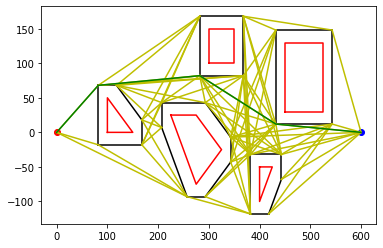

In [155]:
plt.plot(start[0], start[1], 'or')

for idx, obstacle in enumerate(obstacles):
    x = [point[0] for point in obstacle]
    y = [point[1] for point in obstacle]
    x.append(obstacle[0][0])
    y.append(obstacle[0][1])
    
    plt.plot(x, y, 'r-')
    
for idx, simplices in enumerate(padded_simplices):
    for simplex in simplices:
        plt.plot(simplex[0], simplex[1], 'k-')
x = plt.plot(goal[0], goal[1], 'ob')

for segment in itertools.chain.from_iterable(all_free_segments):
    plt.plot([segment[0].x, segment[1].x], [segment[0].y, segment[1].y], 'y-')

x_goal_path = [point.x for point in path_to_goal]
y_goal_path = [point.y for point in path_to_goal]
plt.plot(x_goal_path, y_goal_path, 'g-')

In [147]:
# convert all_free_segments to node with edge nodes + weight
# reduce to one point with neighbours

In [40]:
def plot_map(start, goal, obstacles):
    # Create a black image
    img = np.full((600, 1200, 3), 255, np.uint8)

    obs = []
    # draw obstacles
    for ob in obstacles:
        ob = map2img(ob)
        obs.append(ob)
        # print(len(ob))
        # print(ob)
        cv2.fillConvexPoly(img, ob.reshape(-1, 1, 2), (255,255,0))

    # draw start and goal point
    goal_img = tuple(map2img([goal])[0])
    start_img = tuple(map2img([start])[0])
    circ1 = cv2.circle(img, goal_img, 7, (100, 0, 0), -1)
    circ2 = cv2.circle(img, start_img, 7, (0, 0, 100), -1)
    
    fig = plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.show()

In [ ]:
# Create a black image
img = np.full((600, 1200, 3), 255, np.uint8)
    
obs = []
# draw obstacles
for ob in obstacles:
    ob = map2img(ob)
    obs.append(ob)
    # print(len(ob))
    # print(ob)
    cv2.fillConvexPoly(img, ob.reshape(-1, 1, 2), (255,255,0))

# draw start and goal point
goal_img = tuple(map2img([goal])[0])
start_img = tuple(map2img([start])[0])
circ1 = cv2.circle(img, goal_img, 7, (100, 0, 0), -1)
circ2 = cv2.circle(img, start_img, 7, (0, 0, 100), -1)

In [ ]:
fig = plt.figure(figsize=(20, 20))
# ax = fig.gca()
# ax.set_xticks(np.arange(0, 1, 1))
# ax.set_yticks(np.arange(0, 1, 1))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Create a black image
img = np.full((600, 1200, 3), 255, np.uint8)

obs = []
# draw obstacles
for ob in obstacles:
    ob = map2img(ob)
    obs.append(ob)
    # print(len(ob))
    # print(ob)
    cv2.fillConvexPoly(img, ob.reshape(-1, 1, 2), (255,255,0))

# draw start and goal point
goal_img = tuple(map2img([goal])[0])
start_img = tuple(map2img([start])[0])
circ1 = cv2.circle(img, goal_img, 7, (100, 0, 0), -1)
circ2 = cv2.circle(img, start_img, 7, (0, 0, 100), -1)

fig = plt.figure(figsize=(20, 20))
ax = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
boundary_points = hulls[0].points[hulls[0].vertices]
plt.plot(boundary_points[:,0], boundary_points[:,1], 'ko')

In [ ]:
start_obs_segments2 = [(start_point, obs_point) for obs_point in list(itertools.chain.from_iterable(obstacle_points))]
start_obs_segments2.append((start_point, goal_point))

In [ ]:
extract_non_intersecting_lines(start_obs_segments2, obstacle_segments)

In [ ]:
# # computing line segments for one convex hull edge
# obs_point_segments = [(obstacle_points[0][i], obstacle_points[0][i+1]) for i in range(len(obstacle_points[0]) - 1) ]
# if len(obstacle_points[0]) > 2:
#     obs_point_segments.append((obstacle_points[0][-1], obstacle_points[0][0]))
# obs_point_segments

In [ ]:
# # from start point to points in convex hull
# start_obs_segments = [(start_point, obs_point) for obs_point in obstacle_points[0]]
# start_obs_segments

In [ ]:
# lines_not_intersect = []
# for idx1, start_obs_segment in enumerate(start_obs_segments):
#     intersect = False

#     for obs_point_segment in obs_point_segments:
#         # skip checks if the end point of the start point is the same as the start or end of the obstacle segment
#         if point_lie_on_segment(obs_point_segment[0], obs_point_segment[1], start_obs_segment[1]):
#             continue
            
#         intersect = segment_intersect(*start_obs_segment, *obs_point_segment)
#         if intersect:
#             break

#     if not intersect:
#         lines_not_intersect.append(start_obs_segment)

# lines_not_intersect

In [ ]:
h = []

In [ ]:
heapq.heappush(h, (5, Point(0,0)))
heapq.heappush(h, (7,  Point(1,0)))
heapq.heappush(h, (1,  Point(3,0)))
heapq.heappush(h, (1,  Point(4,0)))
heapq.heappush(h, (3,  Point(0,0)))

In [ ]:
while len(h) > 0:
    print(heapq.heappop(h))